In [74]:
import os
import pickle
import re
import warnings

import cartopy.crs as ccrs
import earthaccess
import earthpy as et
import geopandas as gpd
import geoviews as gv
import hvplot.pandas
import hvplot.xarray
import numpy as np
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rxrmerge
from tqdm.notebook import tqdm
import xarray as xr
from shapely.geometry import Polygon
from sklearn.cluster import KMeans


In [76]:
os.environ["GDAL_HTTP_MAX_RETRY"] = "5"
os.environ["GDAL_HTTP_RETRY_DELAY"] = "1"

warnings.simplefilter('ignore')

In [78]:
def cached(func_key, override=False):
    """
    A decorator to cache function results
    
    Parameters
    ==========
    key: str
      File basename used to save pickled results
    override: bool
      When True, re-compute even if the results are already stored
    """
    def compute_and_cache_decorator(compute_function):
        """
        Wrap the caching function
        
        Parameters
        ==========
        compute_function: function
          The function to run and cache results
        """
        def compute_and_cache(*args, **kwargs):
            """
            Perform a computation and cache, or load cached result.
            
            Parameters
            ==========
            args
              Positional arguments for the compute function
            kwargs
              Keyword arguments for the compute function
            """
            # Add an identifier from the particular function call
            if 'cache_key' in kwargs:
                key = '_'.join((func_key, kwargs['cache_key']))
            else:
                key = func_key

            path = os.path.join(
                et.io.HOME, et.io.DATA_NAME, 'jars', f'{key}.pickle')
            
            # Check if the cache exists already or override caching
            if not os.path.exists(path) or override:
                # Make jars directory if needed
                os.makedirs(os.path.dirname(path), exist_ok=True)
                
                # Run the compute function as the user did
                result = compute_function(*args, **kwargs)
                
                # Pickle the object
                with open(path, 'wb') as file:
                    pickle.dump(result, file)
            else:
                # Unpickle the object
                with open(path, 'rb') as file:
                    result = pickle.load(file)
                    
            return result
        
        return compute_and_cache
    
    return compute_and_cache_decorator

In [80]:
@cached('region_10', override=False)
def download_watershed_bounds(boundary_filename="WBD_HU2_Shape", huc=10):
    """
    Download a USGS watershed boundary dataset for a given HUC level and filter for Oglala Lakota.

    Args:
        boundary_filename (str): USGS WBD shapefile basename (without .zip).
        huc (int): Hydrologic Unit Code level.

    Returns:
        geopandas.GeoDataFrame: Filtered watershed boundaries for Oglala Lakota.
    """
    # Build full download URL
    water_boundary_url = (
        "https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/WBD/"
        f"HU2/Shape/WBD_10_HU2_Shape.zip"
    )

    # Download and extract data
    wbd_dir = et.data.get_data(url=water_boundary_url)

    # Path to the shapefile
    hu_shape_path = os.path.join(wbd_dir, 'Shape', f'WBDHU{huc}.shp')

    # Read the shapefile
    hu_gdf = gpd.read_file(hu_shape_path, engine='pyogrio')

    # Filter for Oglala Lakota land (Pine Ridge Reservation)
    # Replace 'NAME' with the column name that corresponds to the tribal area, 
    # or use 'TRIBE' or 'STATES' depending on the shapefile schema.
    if 'PLACE' in hu_gdf.columns:
        hu_gdf = hu_gdf[hu_gdf['PLACE'].str.contains("Oglala Lakota", na=False)]

    # Alternatively, if filtering by state (South Dakota)
    if 'STATES' in hu_gdf.columns:
        hu_gdf = hu_gdf[hu_gdf['STATES'].str.contains("SD")]

    return hu_gdf


In [82]:
# Hydrologic Unit level "HU2" indicates a large region 
region = '10'

boundary_filename = f'WBD_10_HU2_Shape'

# HU12: a very small subwatershed within a HU2 region
huc = 12 

wbd_gdf = download_watershed_bounds(boundary_filename, huc)

In [83]:
# Select watershed 

# Circle P Springs-Cheyenne River
watershed = '101301051402'

cheyenne_river_gdf = (
    wbd_gdf[wbd_gdf[f'huc{huc}'] # select HU12 subregion
    .isin([watershed])] # subset for Circle P Springs-Cheyenne River
    .dissolve() # dissolve geometries into single observation
)

In [84]:
# Plot watershed 

(
    cheyenne_river_gdf.to_crs(ccrs.Mercator())
    .hvplot(
        alpha=.2, fill_color='white', tiles='EsriImagery',
        crs=ccrs.Mercator())
    .opts(width=600, height=400)
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [85]:
# Ensure you are logged in with EarthAccess
earthaccess.login(strategy="interactive", persist=True)

# Define the bounding box for Oglala Lakota watershed 
bounding_box_oglala = tuple(cheyenne_river_gdf.total_bounds)  # Use Cheyenne River gdf's bounding box

# Search for HLS data within the Cheyenne River area
cheyenne_river_gdf_results = earthaccess.search_data(
    short_name="HLSL30",  # Harmonized Sentinel/Landsat multispectral dataset
    cloud_hosted=True,
    bounding_box=bounding_box_cheyenne,  # Use Cheyenne River bounding box
    temporal=("2023-10-01", "2023-12-01")  # Temporal range
)

In [86]:
# Print or inspect the search results
print(cheyenne_river_gdf_results)

[Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -101.13001323, 'Latitude': 44.09977092}, {'Longitude': -101.06390244, 'Latitude': 45.08595696}, {'Longitude': -102.29732422, 'Latitude': 45.12184711}, {'Longitude': -102.48149711, 'Latitude': 44.57486079}, {'Longitude': -102.50015121, 'Latitude': 44.13800769}, {'Longitude': -101.13001323, 'Latitude': 44.09977092}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-10-01T17:30:03.020Z', 'EndingDateTime': '2023-10-01T17:30:03.020Z'}}
Size(MB): 167.44002437591553
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TGK.2023274T173003.v2.0/HLS.L30.T13TGK.2023274T173003.v2.0.VAA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TGK.2023274T173003.v2.0/HLS.

In [87]:
@cached('granule_metadata', override=False)
def build_granule_metadata(hls_results):
    """
    Collect granule metadata from HLS tiles.

    Args:
    hls_results (List[DataGranule]): HLS search results list.

    Returns:
    granule_metadata (list): List of granule metadata dictionaries.
    """

    # Find all the metadata in the file
    granule_metadata = [] 

    # Loop through each granule
    for result in tqdm(hls_results):

        # Granule ID
        granule_id = result['umm']['GranuleUR']

        # Get datetime 
        temporal_coverage = result['umm'].get('TemporalExtent', {})
        if temporal_coverage:
            granule_date = pd.to_datetime(
                temporal_coverage['RangeDateTime']['BeginningDateTime']
            ).strftime('%Y-%m-%d')
        else:
            granule_date = 'Unknown'

        print(f'Processing date {granule_date}. Granule ID: {granule_id}.')

        # Assemble granule polygon 
        spatial_ext = result['umm'].get('SpatialExtent', {})
        granule_geo = spatial_ext.get('HorizontalSpatialDomain', {}).get('Geometry', {})
        
        if 'GPolygons' in granule_geo:
            granule_points = granule_geo['GPolygons'][0]['Boundary']['Points']
            granule_coords = [tuple(point.values()) for point in granule_points]
            granule_polygon = Polygon(granule_coords)
        else:
            granule_polygon = None  # Handle cases where no polygon is found

        # Open granule files
        granule_files = earthaccess.open([result])

        # Use regex to extract metadata from the filenames
        uri_re = re.compile(r"v2.0/(HLS.L30.*.tif)")
        tile_id_re = re.compile(r"HLSL30.020/(HLS.L30..*.v2.0)/HLS")
        band_id_re = re.compile(r"HLS.L30..*v2.0.(\D{1}.*).tif")

        # Collect file metadata
        for uri in granule_files:

            # Make sure uri has full_name property
            if hasattr(uri, 'full_name'):
                file_name = uri_re.findall(uri.full_name)
                tile_id = tile_id_re.findall(uri.full_name)
                band_id = band_id_re.findall(uri.full_name)

                # Only proceed if regex returns valid results
                if file_name and tile_id and band_id:
                    file_name = file_name[0]
                    tile_id = tile_id[0]
                    band_id = band_id[0]

                    # Only keep spectral bands and cloud Fmask (exclude sun and view angles)
                    exclude_files = ['SAA', 'SZA', 'VAA', 'VZA']
                    if band_id not in exclude_files:
                        granule_metadata.append({
                            'filename': file_name,
                            'tile_id': tile_id,
                            'band_id': band_id,
                            'granule_id': granule_id,
                            'granule_date': granule_date,
                            'granule_polygon': granule_polygon,
                            'uri': uri
                        })

    # Convert granule metadata to DataFrame
    granule_metadata_df = pd.DataFrame(
        data=granule_metadata, 
        columns=['filename', 'tile_id', 'band_id', 'granule_id', 'granule_date', 'granule_polygon', 'uri']
    )

    # Convert DataFrame to GeoDataFrame
    granule_results_gdf = gpd.GeoDataFrame(
        granule_metadata_df, 
        geometry=granule_metadata_df['granule_polygon'], 
        crs="EPSG:4326"
    )

    return granule_results_gdf


In [88]:
cheyenne_river_gdf_metadata = build_granule_metadata(cheyenne_river_gdf_results)

In [89]:
def process_image(uri, bounds_gdf, masked=True, scale=1):
    """
    Load, crop, and scale a raster image

    Parameters
    ----------
    uri: file-like or path-like
      File accessor 
    bounds_gdf: gpd.GeoDataFrame
      Area of interest (should be in the same CRS as the raster)
    masked: bool, optional
      Whether to mask the raster data (default is True)
    scale: float, optional
      Scaling factor to apply to the raster values (default is 1)

    Returns
    -------
    cropped_da: rxr.DataArray
      Processed and cropped raster data
    """
    # Load and scale the raster data
    da = rxr.open_rasterio(uri, masked=masked).squeeze() * scale

    # Obtain the CRS of the raster
    raster_crs = da.rio.crs

    # Reproject bounds_gdf to match the raster's CRS
    bounds_gdf = bounds_gdf.to_crs(raster_crs)

    # Ensure total_bounds are correctly accessed in the correct CRS
    minx, miny, maxx, maxy = bounds_gdf.total_bounds

    # Clip the raster to the bounds of the area of interest
    cropped_da = da.rio.clip_box(minx, miny, maxx, maxy)

    return cropped_da

In [98]:
def process_mask(da, bits_to_mask):
    """
    Load a DataArray and process to a boolean mask

    Parameters
    ----------
    da: DataArray
      The input DataArray 
    bits_to_mask: list of int
      The indices of the bits to mask if set

    Returns
    -------
    mask: np.array
      Boolean mask
    """
    # Get the mask as bits
    bits = np.unpackbits(
        da.values.astype('uint8').reshape(da.shape + (-1,)), 
        bitorder='little', 
        axis=-1
    )

    # Generate the mask by checking the specified bits 
    mask = np.all(bits[..., bits_to_mask] == 0, axis=-1)

    return mask


In [100]:
# Harmonized Landsat Sentinel-2 (HLS) band code name L8
bands = {
    'B01': 'aerosol',
    'B02': 'red',
    'B03': 'green',
    'B04': 'blue',
    # Near-infrared narrow (0.85 – 0.88 micrometers)
    'B05': 'nir',
    # Short-wave infrared (SWIR) wavelength 1.57 – 1.65 µm
    'B06': 'swir1',
    # SWIR (2.11 – 2.29 µm)
    'B07': 'swir2',
    'B09': 'cirrus',
    # Thermal infrared 1 (10.60 – 11.19 µm)
    'B10': 'thermalir1',
    # Thermal infrared 2 (11.50 – 12.51 µm)
    'B11': 'thermalir2'
}

# HLS Quality Assessment layer bits
bits_to_mask = [
    1, # Cloud
    2, # Adjacent to cloud/shadow
    3  # Cloud shadow
]

In [102]:
@cached('cheyenne_river_reflectance_da_df', override=False)
def compute_reflectance_da(file_df, boundary_gdf):
    """
    Connect to files over VSI (Virtual Filesystem Interface), 
    crop, cloud mask, and wrangle data.
    
    Returns a reflectance DataArray within file DataFrame.
    
    Parameters
    ==========
    file_df : pd.DataFrame
        File connection and metadata 
    boundary_gdf : gpd.GeoDataFrame
        Boundary use to crop the data
    """
    granule_da_rows= []

    # unique dated data granules
    tile_groups = file_df.groupby(['granule_date', 'tile_id'])

    for (granule_date, tile_id), tile_df in tqdm(tile_groups):
        print(f'Processing granule {tile_id} {granule_date}')

        # Grab Fmask row from tile group
        Fmask_row = tile_df.loc[tile_df['band_id'] == 'Fmask']
        # Load cloud path
        cloud_path = Fmask_row.uri.values[0]
        cloud_da = process_image(cloud_path, boundary_gdf, masked=False)
        # Compute cloud mask
        cloud_mask = process_mask(cloud_da, bits_to_mask)

        # Load spectral bands
        band_groups = tile_df.groupby('band_id')

        for band_name, band_df in band_groups:
            for index, row in band_df.iterrows():
                # Process band and retain band scale
                cropped_da = process_image(row.uri, boundary_gdf, scale=0.0001)
                cropped_da.name = band_name

                # Apply mask on band to remove unwanted cloud data
                row['da'] = cropped_da.where(~cropped_da.isin(cloud_mask))

                # Store the resulting DataArray
                granule_da_rows.append(row.to_frame().T)

    # Reassemble the metadata DataFrame
    return pd.concat(granule_da_rows)

In [104]:
cheyenne_river_reflectance_da_df = compute_reflectance_da(cheyenne_river_gdf_metadata, cheyenne_river_gdf)

  0%|          | 0/14 [00:00<?, ?it/s]

Processing granule HLS.L30.T13TGK.2023274T173003.v2.0 2023-10-01
Processing granule HLS.L30.T14TLQ.2023274T173003.v2.0 2023-10-01
Processing granule HLS.L30.T13TGK.2023282T173004.v2.0 2023-10-09
Processing granule HLS.L30.T14TLQ.2023282T173004.v2.0 2023-10-09
Processing granule HLS.L30.T13TGK.2023290T173004.v2.0 2023-10-17
Processing granule HLS.L30.T14TLQ.2023290T173004.v2.0 2023-10-17
Processing granule HLS.L30.T13TGK.2023306T173008.v2.0 2023-11-02
Processing granule HLS.L30.T14TLQ.2023306T173008.v2.0 2023-11-02
Processing granule HLS.L30.T13TGK.2023314T173006.v2.0 2023-11-10
Processing granule HLS.L30.T14TLQ.2023314T173006.v2.0 2023-11-10
Processing granule HLS.L30.T13TGK.2023322T173009.v2.0 2023-11-18
Processing granule HLS.L30.T14TLQ.2023322T173009.v2.0 2023-11-18
Processing granule HLS.L30.T13TGK.2023330T173014.v2.0 2023-11-26
Processing granule HLS.L30.T14TLQ.2023330T173014.v2.0 2023-11-26


In [105]:
@cached('cheyenne_river_reflectance_da', override=False)
def create_composite_da(granule_da_df):
    """
    Create a composite DataArray from a DataFrame containing granule
    metadata and corresponding DataArrays.

    Args:
    granule_da_df (pandas.DataFrame): Granule metadata DataFrame. 

    Returns:
    xarray.DataArray: Composite granule DataArray. 
    """
    composite_das = []

    for band, band_df in tqdm(granule_da_df.groupby('band_id')):
        merged_das = []

        if (band != 'Fmask'):
            for granule_date, date_df in tqdm(band_df.groupby('granule_date')):

                # For each date merge granule DataArrays
                merged_da = rxrmerge.merge_arrays(list(date_df.da))

                # Mask all negative values
                merged_da = merged_da.where(merged_da > 0)
                merged_das.append(merged_da)

            # Create composite images across dates (by median date) 
            # to fill cloud gaps
            composite_da = xr.concat(
                merged_das, dim='granule_date').median('granule_date')

            # Add the band as a dimension
            composite_da['band'] = int(band[1:])
            
            # Name the composite DataArray
            composite_da.name = 'reflectance'

            composite_das.append(composite_da)

    # Concatenate on the band dimension
    return xr.concat(composite_das, dim='band')

In [106]:
cheyenne_river_reflectance_da = create_composite_da(cheyenne_river_reflectance_da_df)

# Drop thermal bands
cheyenne_river_reflectance_da = cheyenne_river_reflectance_da.drop_sel(band=[10, 11])

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [107]:
# Convert spectral DataArray to a tidy DataFrame
cheyenne_river_reflectance_df = (
    cheyenne_river_reflectance_da.to_dataframe()
    .reflectance # select reflectance values
    .unstack('band')
).dropna()

cheyenne_river_reflectance_df

band                             1       2       3       4       5       6  \
y            x                                                               
4.960574e+06 806891.314473  0.0460  0.0546  0.0754  0.0839  0.1785  0.2676   
             806921.314473  0.0457  0.0533  0.0732  0.0820  0.1823  0.2688   
             806951.314473  0.0407  0.0497  0.0659  0.0757  0.1661  0.2398   
             806981.314473  0.0381  0.0461  0.0617  0.0776  0.1543  0.2260   
             807011.314473  0.0397  0.0466  0.0660  0.0780  0.1871  0.2420   
...                            ...     ...     ...     ...     ...     ...   
4.946024e+06 798431.314473  0.0393  0.0537  0.0766  0.1005  0.2168  0.2602   
             798461.314473  0.0345  0.0455  0.0666  0.0845  0.1826  0.2168   
             798491.314473  0.0270  0.0385  0.0549  0.0677  0.1594  0.1993   
             798521.314473  0.0305  0.0421  0.0614  0.0763  0.1728  0.2232   
             798551.314473  0.0371  0.0490  0.0692  0.0890  0.1919  0.2519   

band                             7       9  
y            x                              
4.960574e+06 806891.314473  0.1845  0.0013  
             806921.314473  0.1786  0.0012  
             806951.314473  0.1599  0.0015  
             806981.314473  0.1504  0.0018  
             807011.314473  0.1538  0.0015  
...                            ...     ...  
4.946024e+06 798431.314473  0.1652  0.0011  
             798461.314473  0.1354  0.0015  
             798491.314473  0.1241  0.0015  
             798521.314473  0.1415  0.0014  
             798551.314473  0.1525  0.0013  

[158742 rows x 8 columns]

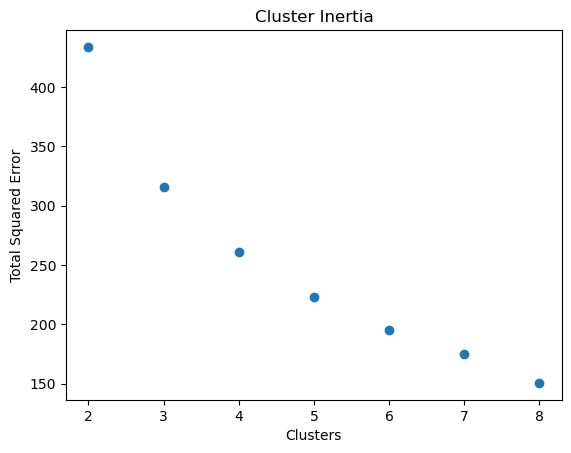

In [108]:
import matplotlib.pyplot as plt

# Collect the total squared clustering error for each k
k_inertia = []

# Experiment with different k values 
k_values = list(range(2, 9))

for k in k_values:

    # Create model with k clusters
    k_means = KMeans(n_clusters = k)

    model_vars = (
        cheyenne_river_reflectance_df
        [[1, 2, 3, 4, 5, 6, 7, 9]])

    # Fit model 
    k_means.fit(model_vars)
    
    # Calculate inertia
    k_inertia.append(k_means.inertia_)

plt.scatter(x=k_values, y=k_inertia)
plt.title('Cluster Inertia')
plt.xlabel("Clusters")
plt.ylabel("Total Squared Error")
plt.show()

In [112]:
# k-means model with k clusters
k_means = KMeans(n_clusters = 5)

model_vars = (
    cheyenne_river_reflectance_df
    [[1, 2, 3, 4, 5, 6, 7, 9]])

# Fit the model to the spectral bands
k_means.fit(model_vars)

# Add the cluster labels to the dataframe
cheyenne_river_reflectance_df['cluster'] = k_means.labels_

# Inspect labels
cheyenne_river_reflectance_df

band                             1       2       3       4       5       6  \
y            x                                                               
4.960574e+06 806891.314473  0.0460  0.0546  0.0754  0.0839  0.1785  0.2676   
             806921.314473  0.0457  0.0533  0.0732  0.0820  0.1823  0.2688   
             806951.314473  0.0407  0.0497  0.0659  0.0757  0.1661  0.2398   
             806981.314473  0.0381  0.0461  0.0617  0.0776  0.1543  0.2260   
             807011.314473  0.0397  0.0466  0.0660  0.0780  0.1871  0.2420   
...                            ...     ...     ...     ...     ...     ...   
4.946024e+06 798431.314473  0.0393  0.0537  0.0766  0.1005  0.2168  0.2602   
             798461.314473  0.0345  0.0455  0.0666  0.0845  0.1826  0.2168   
             798491.314473  0.0270  0.0385  0.0549  0.0677  0.1594  0.1993   
             798521.314473  0.0305  0.0421  0.0614  0.0763  0.1728  0.2232   
             798551.314473  0.0371  0.0490  0.0692  0.0890  0.1919  0.2519   

band                             7       9  cluster  
y            x                                       
4.960574e+06 806891.314473  0.1845  0.0013        4  
             806921.314473  0.1786  0.0012        4  
             806951.314473  0.1599  0.0015        1  
             806981.314473  0.1504  0.0018        1  
             807011.314473  0.1538  0.0015        4  
...                            ...     ...      ...  
4.946024e+06 798431.314473  0.1652  0.0011        4  
             798461.314473  0.1354  0.0015        1  
             798491.314473  0.1241  0.0015        1  
             798521.314473  0.1415  0.0014        1  
             798551.314473  0.1525  0.0013        4  

[158742 rows x 9 columns]

In [130]:
# Select RGB bands 
rgb = cheyenne_river_reflectance_da.sel(band=[4, 3, 2])

# Scale reflectance from [0,1] to [0,255]
rgb_uint8 = (rgb * 255).astype(np.uint8)

# Brighten the image
rgb_bright = rgb_uint8 * 5
rgb_sat = rgb_bright.where(rgb_bright < 255, 255)

# Plot the brightened, saturated RGB image
rgb_sat.hvplot.rgb(
    x='x', y='y', bands='band',
    data_aspect=1,
    title="Circle P Springs-Cheyenne River",
    max_height=1500,
    max_width=20000,
    xaxis=None, yaxis=None
)


:RGB   [x,y]   (R,G,B)

In [132]:
# The cluster dataframe 
cheyenne_river_reflectance_df.cluster.to_xarray().sortby(['x', 'y']).hvplot(
    cmap="Colorblind", 
    aspect='equal',
    title="Circle P Springs-Cheyenne River",
    max_height=1000, 
    max_width=20000
)


:Image   [x,y]   (cluster)